# Entrega 2 - Predictor de muerte de pacientes con HIV utilizando Naive Bayes

## 1. Objetivo

El objetivo principal de esta tarea es construir un algoritmo capaz de predecir la muerte de pacientes bajo observación por HIV utilizando árboles de decisión generados con el algoritmo ID3 visto en el curso. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan todos censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.


In [ ]:
import funciones
import pandas as pd
import sklearn.preprocessing as sk_pre
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv').drop(columns=['pidnum'])

### 1.1 Antecedentes

## 2. Diseño del predictor

### 2.1 Categorización de atributos

Como ya se mencionó en el apartado anterior, el dataset cuenta con atributos numéricos continuos. Tomamos la decisión de que nuestra estrategia para implementar la extensión de ID3 para dichos atributos y el preprocesamiento, sea la misma:

Se categorizan las variables que toman valores numéricos continuos, o valores discretos dentro de un intervalo amplio. Es decir, para cada atributo a categorizar, se generan rangos, y cada valor es reemplazado por el índice del rango en el que se encuentra, reduciendo así la cantidad de valores distintos que puede tomar cada atributo.

Para categorizar un atributo, se determinan los puntos de corte que maximizan la ganancia de información. El proceso comienza calculando todos los puntos de corte posibles para ese atributo. Estos puntos se definen como los promedios de cada par de valores contiguos en el conjunto ordenado de valores del atributo (X) y que además deben corresponder a diferentes valores de la variable objetivo (Y). A continuación, se calcula la ganancia de información para cada uno de estos puntos de corte. Se seleccionan aquellos puntos que proporcionan la mayor ganancia de información, respetando el límite impuesto por max_range_split. Finalmente, los valores originales del atributo se reemplazan con el índice del rango al que pertenecen, simplificando el modelo.

Tomando en cuenta las observaciones hechas a las columnas y los valores del dataset, los atributos a categorizar son:

- time
- age
- wtkg
- karnof
- preanti
- cd40
- cd420
- cd80
- cd820

Además, el dataset posee una columna `pidnum` que es el identificador de cada observación. Al ser esto un metadato y no un dato de la realidad que influya en el resultado, esta columna se elimina del dataset, para evitar agregar ruído al modelo.

In [ ]:
atributos_a_categorizar = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

 ### 2.3 Entrenamiento del predictor y evaluación.

Para realizar el entrenamiento, ajuste de la solución y evaluación del modelo, el dataset es separado en 3 conjuntos:

- Entrenamiento (70%): Utilizado para entrenar el árbol con el algoritmo ID3
- Validación (15%): Para ajustar los valores de los hiperparametros
- Evaluación (15%): Para probar la precisión del modelo una vez finalizado.

Además, a la hora de separarlos, utilizamos el parámetro `stratify=Y` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $

Estas métricas serán acompañadas con la visualización de la matriz de confusión correspondiente.

In [ ]:
X = dataset.copy().drop(columns=[OBJETIVO])
Y = dataset[OBJETIVO].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 12345, stratify=Y)
X_train, X_validacion, Y_train, Y_validacion = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 12345, stratify=Y_train)

### Valores posibles

In [ ]:
valores_posibles = {}

for categoria in dataset.columns:
    valores_posibles[categoria] = dataset[categoria].unique()

### 2.4 Linea base 

Podemos trazar como línea base de nuestro predictor un modelo sencillo el cual siempre predice que el resultado será la clase más probable.

In [ ]:
dataset.cid.value_counts()

cid
0    1618
1     521
Name: count, dtype: int64

Vemos que el dataset cuenta con 1618 entradas cuyo resultado es 0 (lo que implica que el paciente no murió durante la observación), y 521 cuyo resultado es 1. 
Tomando esto en cuenta, el predictor simple mencionado anteriormente devolverá que el resultado es siempre 0.
A continuación se muestran los resultados de un modelo con esta característica.

In [ ]:
Y_predicho = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho, objetivo=1)

print('Accuracy de linea base:', accuracy)
print('Precision de linea base:', precision)
print('Recall de linea base:', recall)
print('F1 de linea base:', f1)

AttributeError: module 'funciones' has no attribute 'get_accuracy_precision_recall_f1'

Como era de esperar, el accuracy y precisión son equivalentes a la proporción de entradas cuyo resultado es 0 en el dataset.
Con estos datos, esperamos que el modelo a implementar obtenga mejores resultados que la linea base.

### 2.5 Selección de atributos (TODO)

### 2.6 Otras decisiones

Antes de entrenar el árbol, se guarda el elemento mayoritario de la variable objetivo. Esto se hace por dos razones:

- En el caso que, durante la ejecución del algoritmo ID3 se deba generar una rama para la cual no hay entradas, se coloca como resultado el elemento mayoritario de la variable objetivo.

- Si se debe predecir una entrada la cual contiene un valor en un atributo que no se ha observado, se devuelve como resultado nuevamente el elemento mayoritario de la variable objetivo.

## 3. Experimentación

In [ ]:
m = 100
coso = funciones.NaiveBayesAIDS(m, valores_posibles, atributos_a_categorizar, 0.5)
coso.fit(X_train, Y_train)

In [ ]:
Y_pred = coso.predict(X_validacion)

In [ ]:
accuracy = accuracy_score(Y_validacion, Y_pred)
print(f'accuracy: {accuracy}')

accuracy: 0.8424908424908425


### 3.1 Extensión a atributos continuos

A continuación, se muestran los resultados durante la ejecución del algoritmo ID3 con extensión a atributos continuos ,con `max_range_split=2` y `max_range_split=3`, y utilizando las 3 funciones de selección de atributos mencionadas.

Notar que el eje y comienza en 0.75 para destacar la diferencia entre cada función utilizada.

In [ ]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

funciones.plot_metricas(resultados_max_range_split_2_durante, 2)

print('Resultados para max_range_split_durante = 2:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_2_durante.items():
        print(f'  {key}: {value[i]}')
    print("")  

funciones.plot_metricas(resultados_max_range_split_3_durante, 3)

print('Resultados para max_range_split_durante = 3:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_3_durante.items():
        print(f'  {key}: {value[i]}')
    print("") 

### 3.2 Preprocesando los atributos
A continuación, repetimos el experimento, pero preprocesando el conjunto de datos previo a la ejecución del algoritmo ID3. Para esto, el árbol aplica el algoritmo de categorización, y posteriormente guarda el conjunto de puntos de corte utilizados para cada atributo a categorizar, de forma que pueda luego aplicar los mismos puntos de corte a entradas que no haya visto antes (como pueden ser del conjunto de validación o test).

In [ ]:
# Esta celda puede tardar en ejecutarse puesto que se tienen que entrenar 6 modelos

ArbolDecisionMRS2_entropia_2 = funciones.ArbolDecision()
ArbolDecisionMRS2_entropia_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, True, 2, atributos_a_categorizar)

ArbolDecisionMRS2_gain_ratio_2 = funciones.ArbolDecision()
ArbolDecisionMRS2_gain_ratio_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, True, 2, atributos_a_categorizar)

ArbolDecisionMRS2_impurity_reduction_2 = funciones.ArbolDecision()
ArbolDecisionMRS2_impurity_reduction_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, True, 2, atributos_a_categorizar)

ArbolDecisionMRS3_entropia_2 = funciones.ArbolDecision()
ArbolDecisionMRS3_entropia_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, True, 3, atributos_a_categorizar)

ArbolDecisionMRS3_gain_ratio_2 = funciones.ArbolDecision()
ArbolDecisionMRS3_gain_ratio_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, True, 3, atributos_a_categorizar)

ArbolDecisionMRS3_impurity_reduction_2 = funciones.ArbolDecision()
ArbolDecisionMRS3_impurity_reduction_2.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, True, 3, atributos_a_categorizar)

resultados_max_range_split_2_antes = funciones.entrenar_y_evaluar([ArbolDecisionMRS2_entropia_2, ArbolDecisionMRS2_gain_ratio_2, ArbolDecisionMRS2_impurity_reduction_2], X_validacion, Y_validacion)
resultados_max_range_split_3_antes = funciones.entrenar_y_evaluar([ArbolDecisionMRS3_entropia_2, ArbolDecisionMRS3_gain_ratio_2, ArbolDecisionMRS3_impurity_reduction_2], X_validacion, Y_validacion)

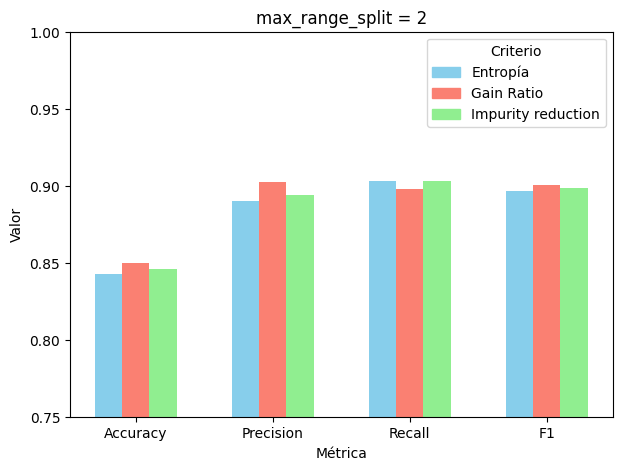

Resultados para max_range_split_antes = 2:
Accuracy:
  Entropia: 0.8424908424908425
  Gain ratio: 0.8498168498168498
  Impurity reduction: 0.8461538461538461

Precision:
  Entropia: 0.8899521531100478
  Gain ratio: 0.9024390243902439
  Impurity reduction: 0.8942307692307693

Recall:
  Entropia: 0.9029126213592233
  Gain ratio: 0.8980582524271845
  Impurity reduction: 0.9029126213592233

F1:
  Entropia: 0.8963855421686746
  Gain ratio: 0.900243309002433
  Impurity reduction: 0.8985507246376813



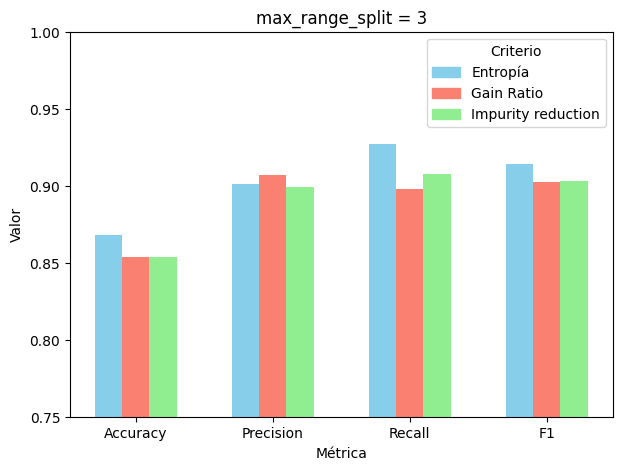

Resultados para max_range_split_antes = 3:
Accuracy:
  Entropia: 0.8681318681318682
  Gain ratio: 0.8534798534798534
  Impurity reduction: 0.8534798534798534

Precision:
  Entropia: 0.9009433962264151
  Gain ratio: 0.9068627450980392
  Impurity reduction: 0.8990384615384616

Recall:
  Entropia: 0.9271844660194175
  Gain ratio: 0.8980582524271845
  Impurity reduction: 0.9077669902912622

F1:
  Entropia: 0.9138755980861244
  Gain ratio: 0.9024390243902438
  Impurity reduction: 0.9033816425120774



In [ ]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

funciones.plot_metricas(resultados_max_range_split_2_antes, 2)

print('Resultados para max_range_split_antes = 2:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_2_antes.items():
        print(f'  {key}: {value[i]}')
    print("")  

funciones.plot_metricas(resultados_max_range_split_3_antes, 3)

print('Resultados para max_range_split_antes = 3:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_3_antes.items():
        print(f'  {key}: {value[i]}')
    print("") 

### 3.3 Análisis de resultados

La siguiente tabla resume los mejores resultados obtenidos dependiendo de cuando se realizó la categorización y del valor de `max_range_split`, indicando que función de elección de atributo fue la que generó dicho valor.

<table>
  <tr>
    <th>Momento de categorización</th>
    <th>Max range split</th>
    <th>Función de elección de atributo</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1</th>
  </tr>
  <tr>
    <td>Durante ejecución ID3</td>
    <td>2</td>
    <td>Gain ratio</td>
    <td>0.8571</td>
    <td>0.9113</td>
    <td>0.8981</td>
    <td>0.9046</td>
  </tr>
  <tr>
    <td>Durante ejecución ID3</td>
    <td>3</td>
    <td>Gain ratio</td>
    <td>0.8755</td>
    <td>0.9300</td>
    <td>0.9029</td>
    <td>0.9163</td>
  </tr>
  <tr>
    <td>Antes de ejecución ID3</td>
    <td>2</td>
    <td>Gain ratio</td>
    <td>0.8498</td>
    <td>0.9024</td>
    <td>0.8981</td>
    <td>0.9002</td>
  </tr>
  <tr>
    <td>Antes de ejecución ID3</td>
    <td>3</td>
    <td>Ganancia de información</td>  
    <td>0.8681</td>
    <td>0.9009</td>
    <td>0.9271</td>
    <td>0.9138</td>
  </tr>
</table>


En general, no se observa un claro superior entre categorizar antes o después de ejecutar ID3, sin embargo, si nos enfocamos únicamente en el accuracy y f1, podemos identificar que los mejores resultados se obtienen utilizando:

- La función gain ratio.
- max-range-split = 3.
- Categorizando los atributos necesarios durante la ejecución del algoritmo ID3.

Si probamos estas características sobre el conjunto de testeo, obtenemos la siguiente matriz de confusión.

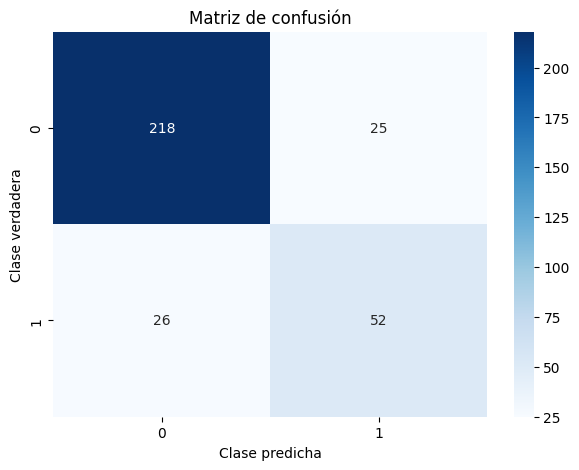

Accuracy: 0.8411214953271028
Precision: 0.8934426229508197
Recall: 0.897119341563786
F1: 0.8952772073921971


In [ ]:
Y_predicho_test = ArbolDecisionMRS3_gain_ratio.predecir(X_test)
funciones.plot_confusion_matrix(Y_test, Y_predicho_test)
accuracy_test, precision_test, recall_test, f1_test = funciones.get_accuracy_precision_recall_f1(Y_test, Y_predicho_test)
print('Accuracy:', accuracy_test)
print('Precision:', precision_test)
print('Recall:', recall_test)
print('F1:', f1_test)

## 4. Comparación

En esta sección se compara el algoritmo ID3 contra la línea base planteada al inicio del documento, además de las implementaciones de la librería scikit-learn:

- DecisionTreeClassifier
- RandomForestClassifier

### 4.1 Preprocesamiento de datos

Para realizar estas comparaciones con la librería `scikit-learn`, primero se preprocesaran los datos ya que estos algoritmos trabajan con atributos numéricos, contrario a la implementación de `ID3` presentada anteriormente. 

Los atributos categóricos `trt` y `strat` utilizan más de 2 categorías en un solo atributo, por lo que estas dos columnas impondrán un orden donde no lo hay, empeorando así el rendimiento de las implementaciones de la librería `scikit-learn`, por lo que se aplica `one-hot encoding` sobre los dos atributos mencionados esperando una mejora en los resultados.

Por otro lado, se observa que en el conjunto de datos no hay elementos faltantes para ningún atributo, por lo que no es necesario realizar preprocesamiento

In [ ]:
X_librerias = dataset.copy().drop(columns=[OBJETIVO, 'pidnum'])
Y_librerias = dataset[OBJETIVO].copy()

X_train_librerias, X_test_librerias, Y_train_librerias, Y_test_librerias = train_test_split(X_librerias, Y_librerias, test_size = 0.15, random_state = 12345, stratify=Y_librerias)
X_train_librerias, X_test_librerias = funciones.aplicar_ohe(dataset, X_train_librerias, X_test_librerias, 'trt')
X_train_librerias, X_test_librerias = funciones.aplicar_ohe(dataset, X_train_librerias, X_test_librerias, 'strat')


Y_predicho_predictor_simple = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

X_train_librerias.drop(['trt','strat'], axis=1, inplace=True)
X_test_librerias.drop(['trt','strat'], axis=1, inplace=True)


Antes de hacer la comparacion, veremos primero cual es el mejor criterio a utilizar en las librerias.

In [ ]:
#Usamos el criterio entropy
ArbolDecisionLibreria_entr = DecisionTreeClassifier(criterion='entropy', random_state=12345)
ArbolDecisionLibreria_entr.fit(X_train_librerias, Y_train_librerias)
Y_predicho_arbol_libreria_entr = ArbolDecisionLibreria_entr.predict(X_test_librerias)

RandomForest_entr = RandomForestClassifier(criterion='entropy', random_state=12345)
RandomForest_entr.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest_entr = RandomForest_entr.predict(X_test_librerias)

# Usamos el criterio gini
ArbolDecisionLibreria_gini = DecisionTreeClassifier(criterion='gini', random_state=12345)
ArbolDecisionLibreria_gini.fit(X_train_librerias, Y_train_librerias)
Y_predicho_arbol_libreria_gini = ArbolDecisionLibreria_gini.predict(X_test_librerias)

RandomForest_gini = RandomForestClassifier(criterion='gini', random_state=12345)
RandomForest_gini.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest_gini = RandomForest_gini.predict(X_test_librerias)

accuracy_arbol_libreria_entr, _, _, f1_arbol_libreria_entr = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_arbol_libreria_entr)
accuracy_random_forest_entr, _, _, f1_random_forest_entr = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest_entr)


accuracy_arbol_libreria_gini, _, _, f1_arbol_libreria_gini = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_arbol_libreria_gini)
accuracy_random_forest_gini, _, _, f1_random_forest_gini = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest_gini)

print("La accuracy del arbol de decision con el criterio entropy es:", accuracy_arbol_libreria_entr)
print("La f1 del arbol de decision con el criterio entropy es:", f1_arbol_libreria_entr)
print("La accuracy del random forest con el criterio entropy es:", accuracy_random_forest_entr)
print("La f1 del random forest con el criterio entropy es:", f1_random_forest_entr)

print("\n")

print("La accuracy del arbol de decision con el criterio gini es:", accuracy_arbol_libreria_gini)
print("La f1 del arbol de decision con el criterio gini es:", f1_arbol_libreria_gini)
print("La accuracy del random forest con el criterio gini es:", accuracy_random_forest_gini)
print("La f1 del random forest con el criterio gini es:", f1_random_forest_gini)

La accuracy del arbol de decision con el criterio entropy es: 0.8286604361370716
La f1 del arbol de decision con el criterio entropy es: 0.8817204301075268
La accuracy del random forest con el criterio entropy es: 0.8847352024922118
La f1 del random forest con el criterio entropy es: 0.9258517034068136


La accuracy del arbol de decision con el criterio gini es: 0.8566978193146417
La f1 del arbol de decision con el criterio gini es: 0.9049586776859505
La accuracy del random forest con el criterio gini es: 0.897196261682243
La f1 del random forest con el criterio gini es: 0.9336016096579477


Podemos observar como los mejores resultados son dados cuando el criterio usado en los algoritmos de `scikit-learn` es `gini`, por lo que usaremos este para las comparaciones con la linea base y nuestro algoritmo manual.

### 4.2 Resultados de la comparación

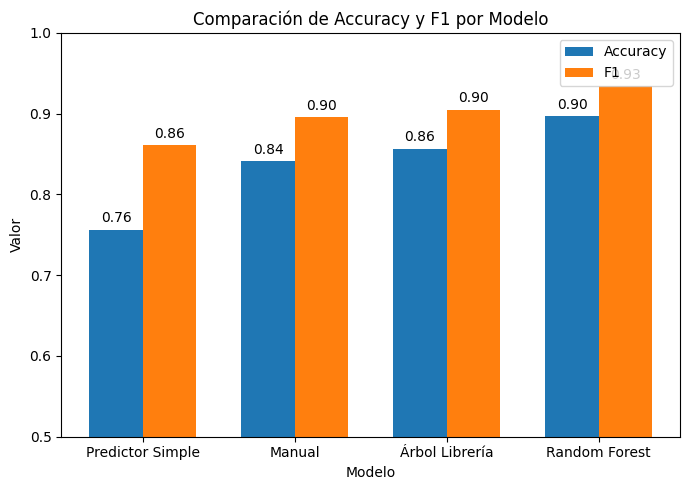

In [ ]:
accuracy_predictor_simple, _, _, f1_predictor_simple = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho_predictor_simple)

funciones.plot_accuracies_and_f1s([accuracy_predictor_simple, accuracy_test, accuracy_arbol_libreria_gini, accuracy_random_forest_gini],
                                  [f1_predictor_simple, f1_test, f1_arbol_libreria_gini, f1_random_forest_gini])

Con la gráfica de arriba, podemos ver cómo se cumplen varias cosas:

- El predictor manual cumple con lo mínimo deseado de estar por encima de la línea base.
- El predictor manual otorga resultados competentes al nivel de la librería usada.
- RandomForest es mejor que nuestra implementación pero no por mucho.


## 5. Conclusiones

A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando árboles de decisión generados con el algoritmo ID3.

En particular, se prueban distintas configuraciones de hiper-parámetros y funciones de atributos. La combinación con mejor resultado fue utilizando la función `gain ratio`, con max_range_split de 3 y categorización _«in situ»_.

Las métricas de clasificación dieron una _accuracy_ de 0.84 y una puntuación f1 de 0.90 para la mejor configuración. Y este es competitivo con la implementación de Árboles de `scikit-learn` y, si bien el rendimiento es estrictamente inferior, es comparable con la implementación de Random Forest de la misma librería. 

Como mejoras a futuro podríamos listar:
- Explorar otros métodos de preprocesamiento de datos, como por ejemplo la selección de atributos en el dataset.
- Probar métodos más complejos como Random Forest.
- Aplicar técnicas para reducir el overfitting en caso de haberlo, como puede ser early stopping.

### Validación cruzada (WIP)

In [ ]:
m = 1000
modeloCV = funciones.NaiveBayesAIDS(m, valores_posibles, atributos_a_categorizar, 0.5)
scores = cross_val_score(modeloCV, X, Y, cv=5 , scoring='accuracy')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/work/funciones.py", line 43, in fit
    Y_copy = Y_train.copy()
             ^^^^^^^
NameError: name 'Y_train' is not defined


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c37fbc8c-fee1-4291-8075-be0e33896680' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>